imports packages

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


creates allocations for bull, bear, and neutral markets

In [23]:
regime_allocations = {
    'bull': {'SPY': 0.7, 'TLT': 0.2, 'GLD': .1},
    'bear': {'SPY': 0.2, 'TLT': 0.5, 'GLD': .3},
    'neutral': {'SPY': 0.5, 'TLT': 0.3, 'GLD': .2}
}
regime_allocations

{'bull': {'SPY': 0.7, 'TLT': 0.2, 'GLD': 0.1},
 'bear': {'SPY': 0.2, 'TLT': 0.5, 'GLD': 0.3},
 'neutral': {'SPY': 0.5, 'TLT': 0.3, 'GLD': 0.2}}

loads the phase 2 data

In [24]:
# load returns + regimes from phase 2
df = pd.read_csv("../data/returns_with_regimes.csv", parse_dates=["Date"])
df = df[["Date", "SPY", "TLT", "GLD", "Regime"]].dropna()
df.set_index("Date", inplace=True)

df.head()


,SPY,TLT,GLD,Regime
Date,,,,
2015-01-05,-0.018225,0.015587,0.014965,2
2015-01-06,-0.009464,0.017856,0.011334,2
2015-01-07,0.012384,-0.001977,-0.005909,2
2015-01-08,0.017590,-0.013332,-0.004217,2
2015-01-09,-0.008046,0.010893,0.011321,1


bases allocations off of HMM regime shifted back a day, calculates portfolio return, static 60/40 SPY/TLT return, 100% SPY return

In [25]:
# map numeric regimes to names
code_to_name = {2: "bear", 0: "neutral", 1: "bull"}
df["RegimeName"] = df["Regime"].map(code_to_name)

assets = ["SPY", "TLT", "GLD"]

# shift regimes so todays return uses yesterday's regime
df["RegimeName_Shifted"] = df["RegimeName"].shift(1)

# compute benchmark returns FIRST on the full set (log returns, no need to shift)
# Static 60/40 SPY/TLT
static_allocations = {'SPY': 0.6, 'TLT': 0.4, 'GLD': 0.0}
df["Static_Return"] = df.apply(lambda r: sum(r[a]*static_allocations[a] for a in assets), axis=1)

# 100% SPY
df["Sp500_Return"] = df["SPY"]

# dros the first row with no prior regime and .copy() to silence warnings
df = df.dropna(subset=["RegimeName_Shifted"]).copy()

df.loc[:, "Portfolio_Return"] = df.apply(
    lambda r: sum(r[a]*regime_allocations[r["RegimeName_Shifted"]][a] for a in assets),
    axis=1
)

df.head()

,SPY,TLT,GLD,Regime,RegimeName,RegimeName_Shifted,Static_Return,Sp500_Return,Portfolio_Return
Date,,,,,,,,,
2015-01-06,-0.009464,0.017856,0.011334,2,bear,bear,0.001464,-0.009464,0.010436
2015-01-07,0.012384,-0.001977,-0.005909,2,bear,bear,0.006640,0.012384,-0.000284
2015-01-08,0.017590,-0.013332,-0.004217,2,bear,bear,0.005221,0.017590,-0.004413
2015-01-09,-0.008046,0.010893,0.011321,1,bull,bear,-0.000470,-0.008046,0.007234
2015-01-12,-0.007864,0.005706,0.011025,0,neutral,bull,-0.002436,-0.007864,-0.003261


graph growth of each allocation set against eachother

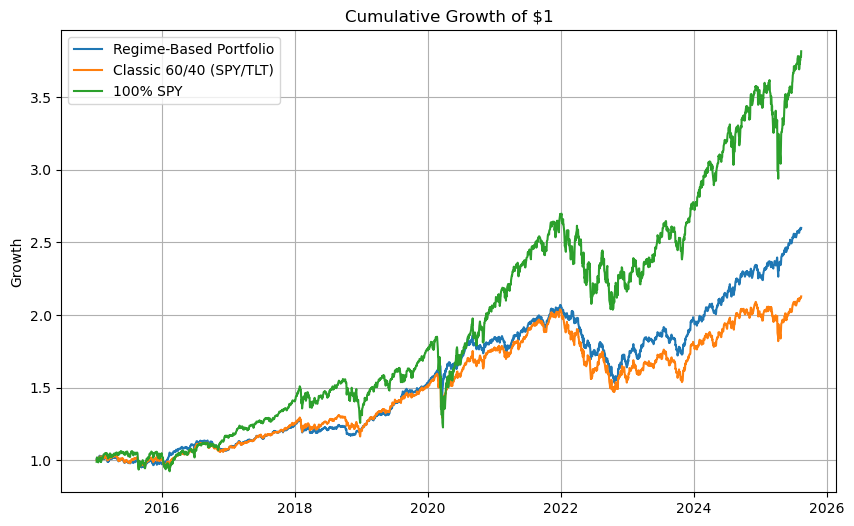

In [26]:
# Cumulative growth from log returns
df["Cumulative_Portfolio"] = np.exp(df["Portfolio_Return"].cumsum())
df["Cumulative_Static"] = np.exp(df["Static_Return"].cumsum())
df["Cumulative_SP500"] = np.exp(df["Sp500_Return"].cumsum())

# Plot all three
plt.figure(figsize=(10,6))
plt.plot(df.index, df["Cumulative_Portfolio"], label="Regime-Based Portfolio")
plt.plot(df.index, df["Cumulative_Static"], label="Classic 60/40 (SPY/TLT)")
plt.plot(df.index, df["Cumulative_SP500"], label="100% SPY")
plt.title("Cumulative Growth of $1")
plt.ylabel("Growth")
plt.legend()
plt.grid(True)
plt.show()




saves df to data

In [27]:
df.to_csv("../data/phase3_final.csv", index=True)  # keeps DateTimeIndex
